In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
!git clone https://github.com/hastagAB/Healthcare-Fraud-Analysis.git

'git' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Load Dataset
Train = pd.read_csv("../dataset/Train.csv")
Train_Beneficiary = pd.read_csv("../dataset/Train_Beneficiary_Data.csv")
Train_Inpatient = pd.read_csv("../dataset/Train_Inpatient_Data.csv")
Train_Outpatient = pd.read_csv("../dataset/Train_Outpatient_Data.csv")

# Adding age column

In [4]:
Train_Beneficiary['DOB'] = pd.to_datetime(Train_Beneficiary['DOB'] , format = '%d/%m/%Y')
Train_Beneficiary['DOD'] = pd.to_datetime(Train_Beneficiary['DOD'],format = '%d/%m/%Y',errors='ignore')
Train_Beneficiary['Age'] = round(((Train_Beneficiary['DOD'] - Train_Beneficiary['DOB']).dt.days)/365)
Train_Beneficiary.Age.fillna(round(((pd.to_datetime('01/12/2009' , format = '%d/%m/%Y') - Train_Beneficiary['DOB']).dt.days)/365),inplace=True)

# Creating Master Dataframe

In [5]:
Train_Inpatient['EncounterType'] = 0
Train_Outpatient['EncounterType'] = 1
frames = [Train_Inpatient, Train_Outpatient]
TrainInAndOut = pd.concat(frames)
TrainInAndOutBenf = pd.merge(TrainInAndOut, Train_Beneficiary, how='inner', on='BeneID')
Master_df = pd.merge(TrainInAndOutBenf, Train, how='inner', on='Provider')

In [6]:
Master_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud
0,BENE11001,CLM46614,4/12/2009,4/18/2009,PRV55912,26000,PHY390922,NaN,NaN,4/12/2009,...,1,2,1,1,36000,3204,60,70,67.0,Yes
1,BENE16973,CLM565430,9/6/2009,9/6/2009,PRV55912,50,PHY365867,PHY327147,NaN,NaN,...,1,2,2,2,24000,2136,450,200,78.0,Yes
2,BENE17521,CLM34721,1/20/2009,2/1/2009,PRV55912,19000,PHY349293,PHY370861,PHY363291,1/20/2009,...,1,2,2,2,19000,1068,100,20,97.0,Yes
3,BENE21718,CLM72336,10/17/2009,11/4/2009,PRV55912,17000,PHY334706,PHY334706,NaN,10/17/2009,...,1,1,2,2,17000,1068,1050,540,88.0,Yes
4,BENE22934,CLM73394,10/25/2009,10/29/2009,PRV55912,13000,PHY390614,PHY323689,PHY363291,10/25/2009,...,1,1,1,2,27000,2136,450,160,80.0,Yes


# Remove DOD with IsDead and droping DOB as we have age

In [7]:
Master_df.loc[Master_df['DOD'].isnull(), 'IsDead'] = '0'
Master_df.loc[(Master_df['DOD'].notnull()), 'IsDead'] = '1'
Master_df = Master_df.drop(['DOD'], axis = 1)
Master_df = Master_df.drop(['DOB'], axis = 1)

In [8]:
Master_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud,IsDead
0,BENE11001,CLM46614,4/12/2009,4/18/2009,PRV55912,26000,PHY390922,NaN,NaN,4/12/2009,...,2,1,1,36000,3204,60,70,67.0,Yes,0
1,BENE16973,CLM565430,9/6/2009,9/6/2009,PRV55912,50,PHY365867,PHY327147,NaN,NaN,...,2,2,2,24000,2136,450,200,78.0,Yes,0
2,BENE17521,CLM34721,1/20/2009,2/1/2009,PRV55912,19000,PHY349293,PHY370861,PHY363291,1/20/2009,...,2,2,2,19000,1068,100,20,97.0,Yes,0
3,BENE21718,CLM72336,10/17/2009,11/4/2009,PRV55912,17000,PHY334706,PHY334706,NaN,10/17/2009,...,1,2,2,17000,1068,1050,540,88.0,Yes,0
4,BENE22934,CLM73394,10/25/2009,10/29/2009,PRV55912,13000,PHY390614,PHY323689,PHY363291,10/25/2009,...,1,1,2,27000,2136,450,160,80.0,Yes,0


# Calculating the number of days the patient was admitted

In [9]:
Master_df['AdmissionDt'] = pd.to_datetime(Master_df['AdmissionDt'] , format = '%m/%d/%Y')
Master_df['DischargeDt'] = pd.to_datetime(Master_df['DischargeDt'],format = '%m/%d/%Y')
Master_df['DaysAdmitted'] = ((Master_df['DischargeDt'] - Master_df['AdmissionDt']).dt.days)+1
Master_df.loc[Master_df['EncounterType'] == 1, 'DaysAdmitted'] = '0'
Master_df[['EncounterType','DaysAdmitted','DischargeDt','AdmissionDt']].head()
Master_df = Master_df.drop(['DischargeDt'], axis = 1)
Master_df = Master_df.drop(['AdmissionDt'], axis = 1)
Master_df.loc[Master_df['DeductibleAmtPaid'].isnull(), 'DeductibleAmtPaid'] = '0'

C:\Users\neema\AppData\Local\Temp\ipykernel_28496\3897007973.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Master_df.loc[Master_df['EncounterType'] == 1, 'DaysAdmitted'] = '0'
C:\Users\neema\AppData\Local\Temp\ipykernel_28496\3897007973.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Master_df.loc[Master_df['DeductibleAmtPaid'].isnull(), 'DeductibleAmtPaid'] = '0'


In [10]:
cols= ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6']

Master_df[cols]= Master_df[cols].replace({np.nan:0})

In [11]:
Master_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,...,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud,IsDead,DaysAdmitted
0,BENE11001,CLM46614,4/12/2009,4/18/2009,PRV55912,26000,PHY390922,NaN,NaN,7866,...,1,1,36000,3204,60,70,67.0,Yes,0,7.0
1,BENE16973,CLM565430,9/6/2009,9/6/2009,PRV55912,50,PHY365867,PHY327147,NaN,0,...,2,2,24000,2136,450,200,78.0,Yes,0,0
2,BENE17521,CLM34721,1/20/2009,2/1/2009,PRV55912,19000,PHY349293,PHY370861,PHY363291,45340,...,2,2,19000,1068,100,20,97.0,Yes,0,13.0
3,BENE21718,CLM72336,10/17/2009,11/4/2009,PRV55912,17000,PHY334706,PHY334706,NaN,V5789,...,2,2,17000,1068,1050,540,88.0,Yes,0,19.0
4,BENE22934,CLM73394,10/25/2009,10/29/2009,PRV55912,13000,PHY390614,PHY323689,PHY363291,71946,...,1,2,27000,2136,450,160,80.0,Yes,0,5.0


In [12]:
for i in cols:
    Master_df[i][Master_df[i]!=0]= 1

Master_df[cols]= Master_df[cols].astype(float)

C:\Users\neema\AppData\Local\Temp\ipykernel_28496\3606032854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Master_df[i][Master_df[i]!=0]= 1
C:\Users\neema\AppData\Local\Temp\ipykernel_28496\3606032854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Master_df[i][Master_df[i]!=0]= 1
C:\Users\neema\AppData\Local\Temp\ipykernel_28496\3606032854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Master_df[i][Master_df[i]!=0]= 1
C

# Calculating Total Diagnosis and Total Procedure

In [13]:
Master_df['TotalDiagnosis'] = (
    Master_df['ClmDiagnosisCode_1'] + 
    Master_df['ClmDiagnosisCode_10'] + 
    Master_df['ClmDiagnosisCode_2'] + 
    Master_df['ClmDiagnosisCode_3'] + 
    Master_df['ClmDiagnosisCode_4'] + 
    Master_df['ClmDiagnosisCode_5'] + 
    Master_df['ClmDiagnosisCode_6'] + 
    Master_df['ClmDiagnosisCode_7'] + 
    Master_df['ClmDiagnosisCode_8'] + 
    Master_df['ClmDiagnosisCode_9']
)

Master_df['TotalProcedure'] = (
    Master_df['ClmProcedureCode_1'] + 
    Master_df['ClmProcedureCode_2'] + 
    Master_df['ClmProcedureCode_3'] + 
    Master_df['ClmProcedureCode_4'] + 
    Master_df['ClmProcedureCode_5'] + 
    Master_df['ClmProcedureCode_6']
)

In [14]:
remove=['Provider','BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode','DeductibleAmtPaid','NoOfMonths_PartACov',
        'NoOfMonths_PartBCov','DiagnosisGroupCode',
        'State', 'County']

Master_df.drop(columns=remove, axis=1, inplace=True)

In [15]:
Master_df.head(10)

,InscClaimAmtReimbursed,EncounterType,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud,IsDead,DaysAdmitted,TotalDiagnosis,TotalProcedure
0,26000,0,1,1,0,1,2,1,2,2,...,36000,3204,60,70,67.0,Yes,0,7.0,9.0,0.0
1,50,1,1,1,0,1,1,1,2,2,...,24000,2136,450,200,78.0,Yes,0,0,9.0,0.0
2,19000,0,2,1,0,1,1,1,2,1,...,19000,1068,100,20,97.0,Yes,0,13.0,9.0,2.0
3,17000,0,1,1,0,2,2,2,2,2,...,17000,1068,1050,540,88.0,Yes,0,19.0,9.0,1.0
4,13000,0,2,1,0,2,1,2,2,1,...,27000,2136,450,160,80.0,Yes,0,5.0,7.0,1.0
5,3000,0,2,2,0,1,2,2,1,2,...,3000,1068,8900,740,85.0,Yes,0,5.0,1.0,1.0
6,20,1,1,2,0,1,1,1,1,2,...,17000,2136,3810,40,63.0,Yes,0,0,0.0,0.0
7,10000,0,1,1,0,2,1,2,1,1,...,10000,1068,550,190,76.0,Yes,0,4.0,10.0,1.0
8,18000,0,2,1,Y,1,1,1,2,2,...,18000,1068,1440,520,51.0,Yes,0,9.0,9.0,0.0
9,13000,0,2,2,Y,1,1,1,1,1,...,51320,6408,770,300,77.0,Yes,0,22.0,9.0,1.0


# Creating Disease Indicator as a switch

In [16]:
Master_df['RenalDiseaseIndicator'] = Master_df['RenalDiseaseIndicator'].replace({'Y':1,'0':0})
Master_df['RenalDiseaseIndicator'] = Master_df['RenalDiseaseIndicator'].astype(int)

In [17]:
Master_df.describe(include='O')

,PotentialFraud,IsDead,DaysAdmitted
count,558211,558211,558211
unique,2,2,37
top,No,0,0
freq,345415,554080,517737


Formatting the values

In [18]:
Master_df['IsDead']=Master_df['IsDead'].astype(float)
Master_df['DaysAdmitted']=Master_df['DaysAdmitted'].astype(float)
Master_df['PotentialFraud']=Master_df['PotentialFraud'].replace({'Yes':1, 'No':0})
Master_df['PotentialFraud']=Master_df['PotentialFraud'].astype(int)

In [19]:
x = Master_df.drop('PotentialFraud', axis=1)
y = Master_df.loc[:,'PotentialFraud']

In [20]:
x.columns

Index(['InscClaimAmtReimbursed', 'EncounterType', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'IsDead',
       'DaysAdmitted', 'TotalDiagnosis', 'TotalProcedure'],
      dtype='object')

In [21]:
num_col= ['InscClaimAmtReimbursed',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
       'DaysAdmitted', 'TotalDiagnosis', 'TotalProcedure']

cat_col= ['EncounterType', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke','IsDead']

x_cat= x.loc[:,cat_col]
x_cat.head()

,EncounterType,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IsDead
0,0,1,1,0,1,2,1,2,2,1,1,1,2,1,1,0.0
1,1,1,1,0,1,1,1,2,2,2,2,1,2,2,2,0.0
2,0,2,1,0,1,1,1,2,1,2,2,1,2,2,2,0.0
3,0,1,1,0,2,2,2,2,2,2,2,1,1,2,2,0.0
4,0,2,1,0,2,1,2,2,1,2,1,1,1,1,2,0.0


In [22]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x_num = scale.fit_transform(x[num_col])

In [40]:
x_num= pd.DataFrame(x_num, columns=[
                                    'InscClaimAmtReimbursed',
                                    'IPAnnualReimbursementAmt', 
                                    'IPAnnualDeductibleAmt',
                                    'OPAnnualReimbursementAmt', 
                                    'OPAnnualDeductibleAmt', 
                                    'Age','DaysAdmitted', 
                                    'TotalDiagnosis', 
                                    'TotalProcedure'
                                    ])

x= pd.concat([x_num, x_cat], axis=1)
print(x.columns)
# y.head()

Index(['InscClaimAmtReimbursed', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Age', 'DaysAdmitted', 'TotalDiagnosis',
       'TotalProcedure', 'EncounterType', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IsDead'],
      dtype='object')


# Test Train Split

In [24]:
from sklearn.model_selection import train_test_split

x_train,x_test, y_train, y_test= train_test_split(x,y, test_size=0.1, random_state=42)

acc_score = []

# Machine Learning Models

# Decision Tree

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

estimator=  DecisionTreeClassifier()

param_grid= {
    'criterion':[
                 'gini', 'entropy'
                 ],
             'max_depth':[3,4,5],
             'min_samples_split':[2,3,5]
             }

grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid)
grid_search.fit(x_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.6301391943026956
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}


# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

estimator1= RandomForestClassifier()
estimator1.fit(x_train, y_train)
model_score= estimator1.predict(x_train)
accuracy= estimator1.predict(x_test)
acc_score.append({'Model':'Random Forest', 'Score': accuracy_score(y_train, model_score), 'Accuracy': accuracy_score(y_test, accuracy)})
print(accuracy_score(y_train, model_score))
print(accuracy_score(y_test, accuracy))

0.9911761603060577
0.6983447386335137


In [27]:
confusion_matrix(y_test,accuracy)

array([[28419,  6269],
       [10570, 10564]], dtype=int64)

# Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
bayes= GaussianNB()
bayes.fit(x_train, y_train)
train_pred= bayes.predict(x_train)
test_pred= bayes.predict(x_test)
acc_score.append({'Model':'Naive Bayes', 'Score': accuracy_score(y_train, model_score), 'Accuracy': accuracy_score(y_test, accuracy)})
print(accuracy_score(y_train,train_pred))
print(accuracy_score(y_test,test_pred))

0.6233496354418588
0.6254881587904411


In [29]:
confusion_matrix(y_test,test_pred)

array([[31737,  2951],
       [17955,  3179]], dtype=int64)

# Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()
lr.fit(x_train, y_train)
train_pred= lr.predict(x_train)
test_pred= lr.predict(x_test)
acc_score.append({'Model': "Logistic Regression", 'Score': accuracy_score(y_train,train_pred), 'Accuracy': accuracy_score(y_test,test_pred)})
print(accuracy_score(y_train,train_pred))
print(accuracy_score(y_test,test_pred))

0.6299401459824956
0.6318297445451614


In [31]:
confusion_matrix(y_test,test_pred)

array([[32902,  1786],
       [18766,  2368]], dtype=int64)

In [32]:
estimator=  DecisionTreeClassifier(criterion= 'gini', max_depth=5, min_samples_split= 2)
estimator.fit(x_train, y_train)
model_score= estimator.predict(x_train)
accuracy= estimator.predict(x_test)
acc_score.append({'Model':'Decision Tree', 'Score': accuracy_score(y_train, model_score), 'Accuracy': accuracy_score(y_test, accuracy)})

[Text(0.5, 0.9166666666666666, 'DaysAdmitted <= 0.007\ngini = 0.472\nsamples = 502389\nvalue = [310727, 191662]\nclass = No'),
 Text(0.25, 0.75, 'Race <= 2.5\ngini = 0.464\nsamples = 466069\nvalue = [295441, 170628]\nclass = No'),
 Text(0.125, 0.5833333333333334, 'OPAnnualDeductibleAmt <= 10.514\ngini = 0.462\nsamples = 439617\nvalue = [280635, 158982]\nclass = No'),
 Text(0.0625, 0.4166666666666667, 'Race <= 1.5\ngini = 0.462\nsamples = 439548\nvalue = [280621, 158927]\nclass = No'),
 Text(0.03125, 0.25, 'Age <= 0.709\ngini = 0.463\nsamples = 393312\nvalue = [250410, 142902]\nclass = No'),
 Text(0.015625, 0.08333333333333333, 'gini = 0.461\nsamples = 297837\nvalue = [190422, 107415]\nclass = No'),
 Text(0.046875, 0.08333333333333333, 'gini = 0.467\nsamples = 95475\nvalue = [59988, 35487]\nclass = No'),
 Text(0.09375, 0.25, 'OPAnnualDeductibleAmt <= -0.015\ngini = 0.453\nsamples = 46236\nvalue = [30211, 16025]\nclass = No'),
 Text(0.078125, 0.08333333333333333, 'gini = 0.447\nsamples =

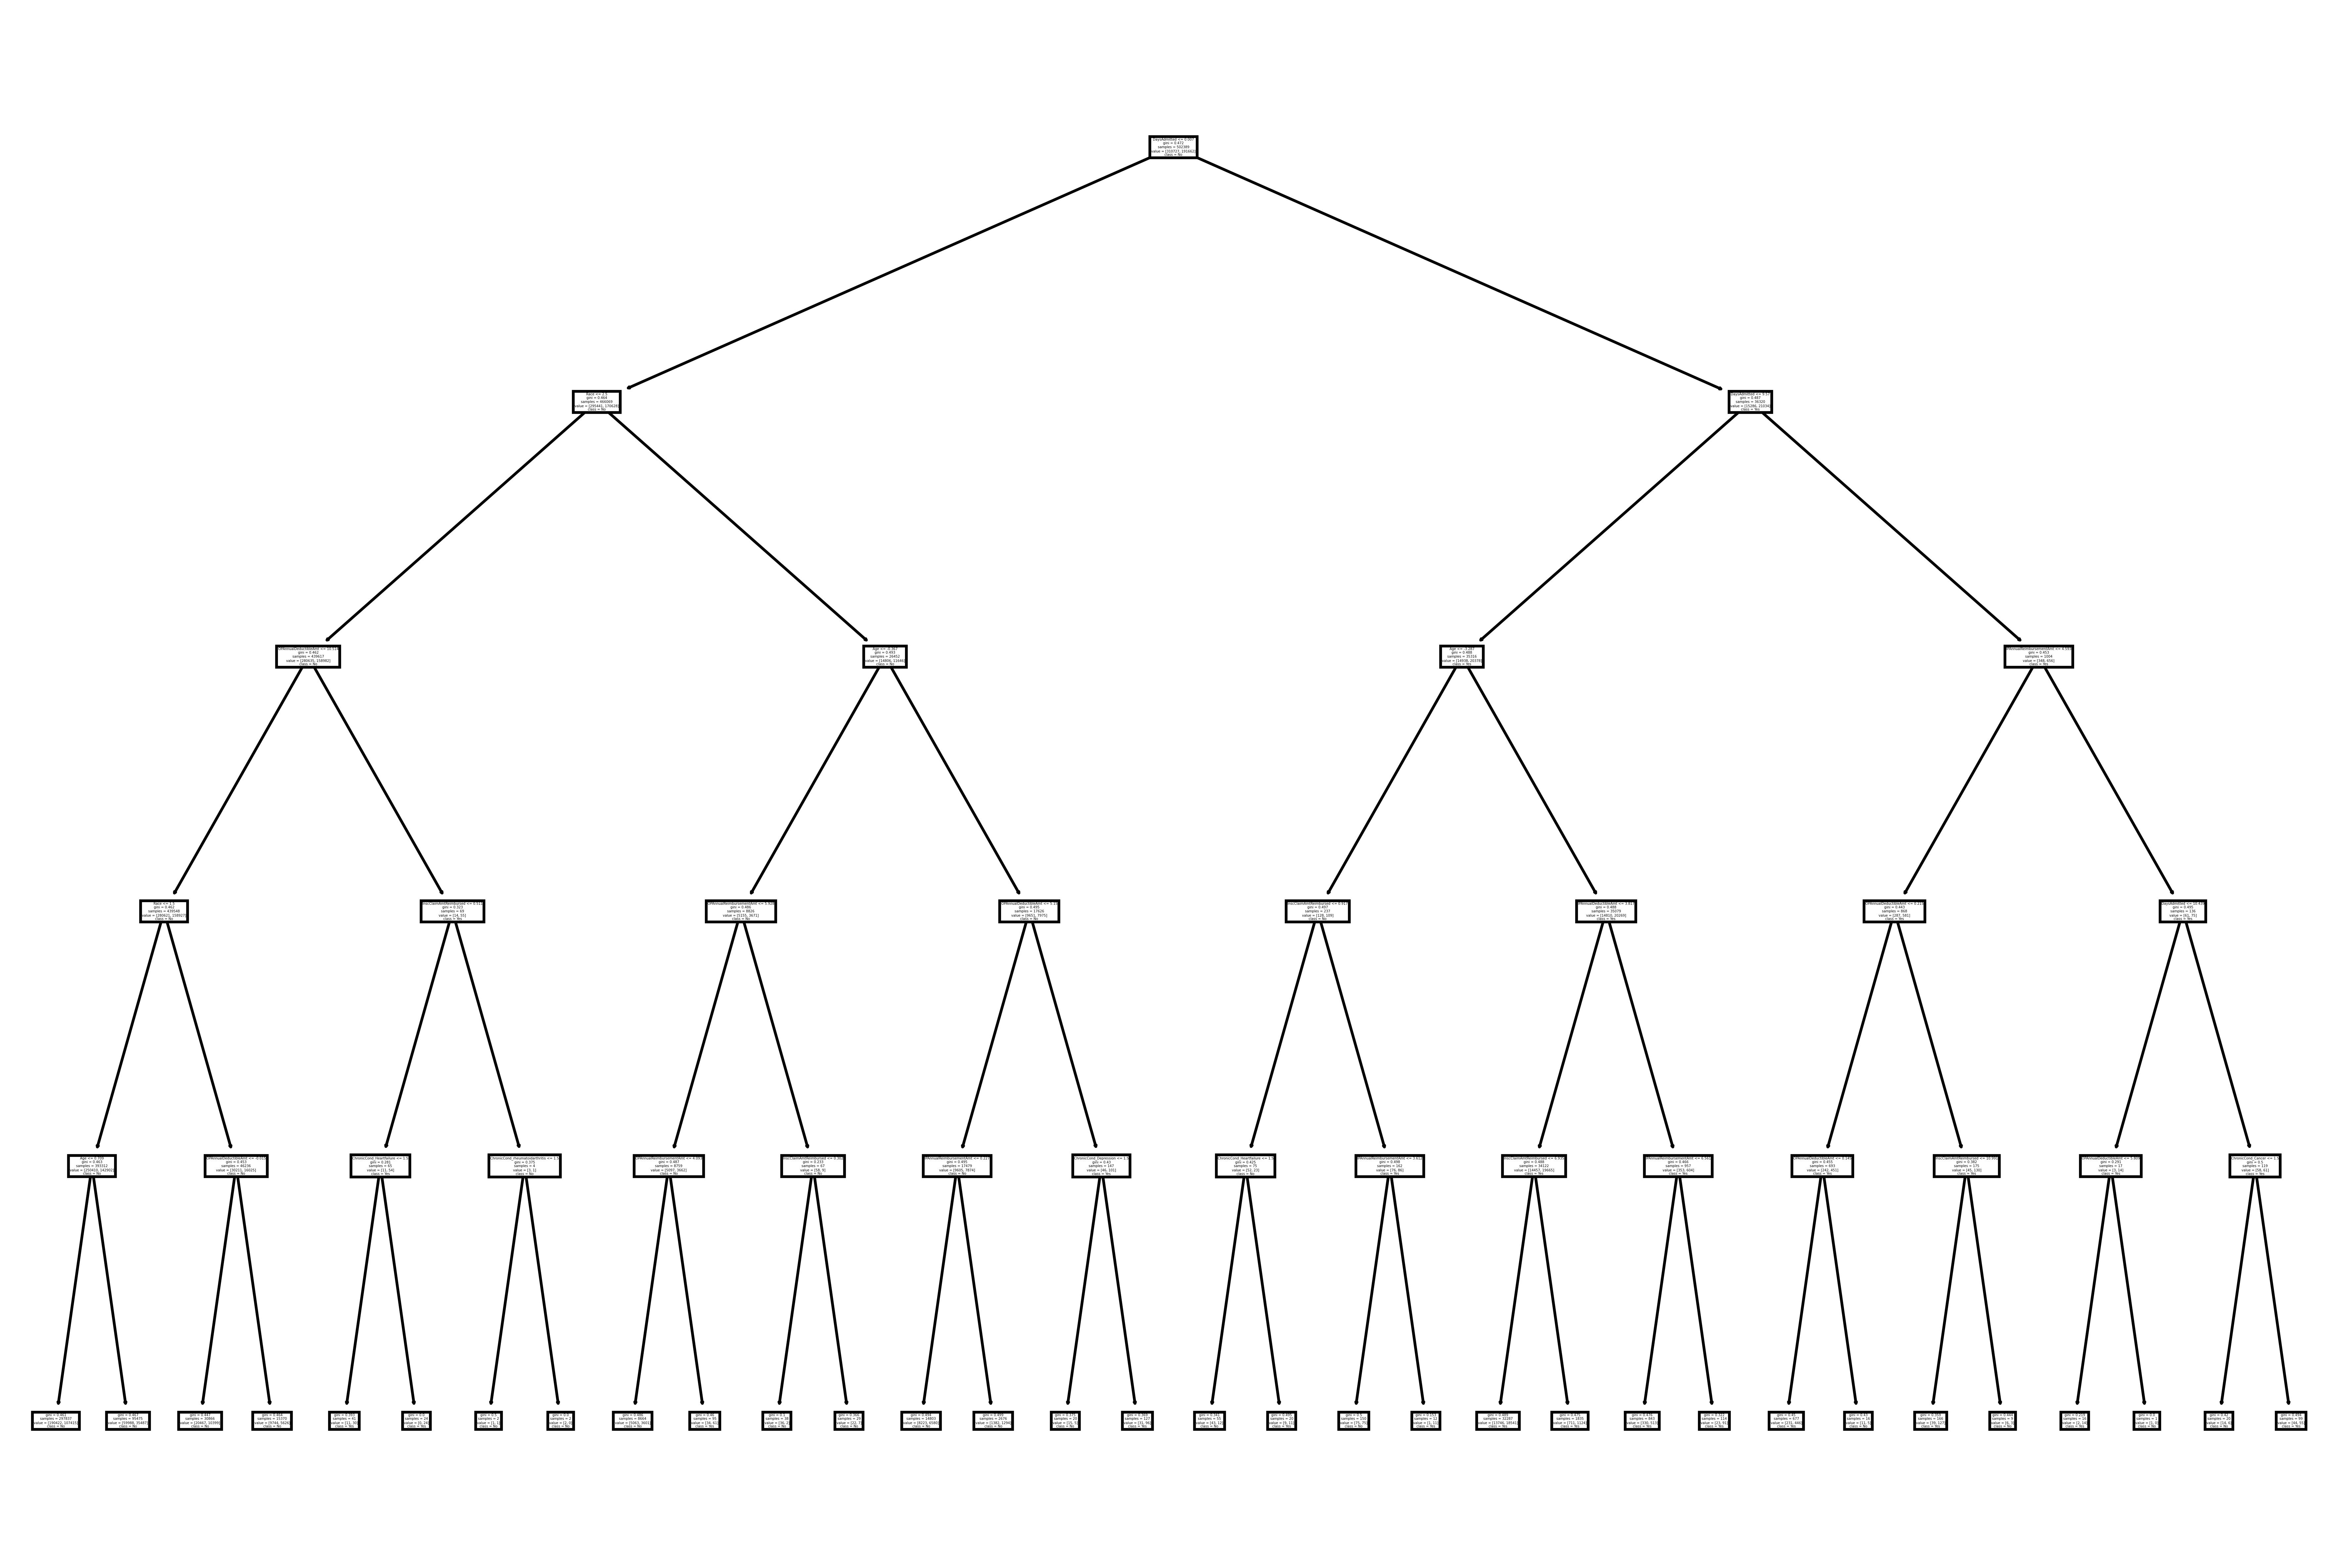

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn import tree

fn= ['InscClaimAmtReimbursed', 'IPAnnualReimbursementAmt',
    'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
    'OPAnnualDeductibleAmt', 'Age', 'DaysAdmitted',
    'TotalDiagnosis', 'TotalProcedure', 'EncounterType', 'Gender', 'Race',
    'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
    'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
    'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
    'ChronicCond_Depression', 'ChronicCond_Diabetes',
    'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
    'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IsDead']

cl=['No','Yes']

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (15,10), dpi=600)
tree.plot_tree(estimator, feature_names= fn, class_names=cl)


In [34]:
confusion_matrix(y_test,accuracy)

array([[32910,  1778],
       [18767,  2367]], dtype=int64)

In [35]:
accuracy= pd.DataFrame(acc_score, columns=['Model','Score','Accuracy'])
accuracy.sort_values(by='Accuracy', ascending= False, inplace= True)
accuracy

,Model,Score,Accuracy
0,Random Forest,0.991176,0.698345
1,Naive Bayes,0.991176,0.698345
3,Decision Tree,0.630306,0.631955
2,Logistic Regression,0.629940,0.631830


<Axes: xlabel='Model', ylabel='Accuracy'>

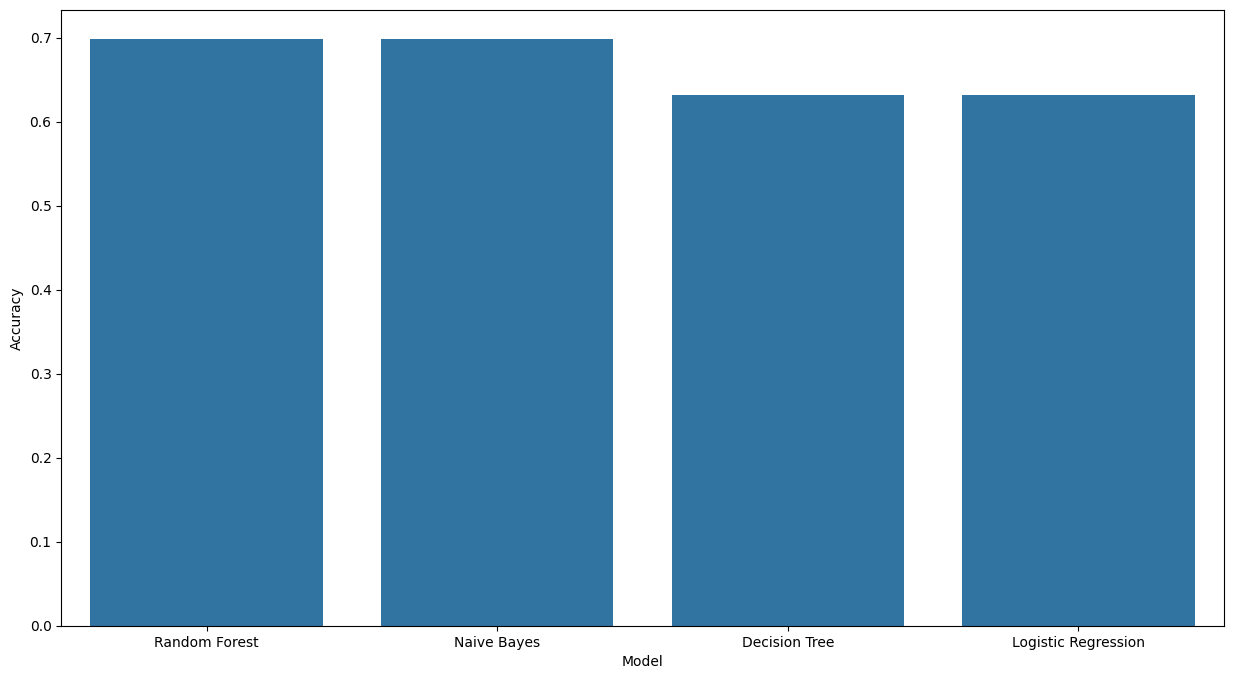

In [36]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.barplot(x= accuracy.Model, y=accuracy.Accuracy)